## 1. Objetivo

- Gerar insight através da análise e manipulação dos dados para auxiliar a tomada de decisão do time de negócio


## 2. Metodologia

### 2.1. Problema de negócio

- Quais são os imóveis que a House Rocket deveria comprar e por qual preço
- Uma vez que o imóvel foi comprado, qual o melhor momento para revendê-lo e por qual preço

### 2.2. Planejamento da solução

- **Saída:**
    - Reposta:
        - Filtrar os imóveis com preço de custo abaixo da média da região.
        - Calcular a margem para revenda em função do preço de custo e a sazonalidade.
    - Entrega:
        - Dashboard interativo.
    - Local:
        - Plataforma cloud.  
    
- **Processo:**
    - Etapas:
        - Agrupar os dados por região.
        - Encontrar a mediana do preço de custo dos imóveis.
        - Identificar os imóveis que estão abaixo do preço mediano de cada região e que estejam em boas condições.
        - Coletar os dados de localização dos imóveis.
        - Agrupar os dados por estação do ano.
        - Definir o preço de revenda:
            - Se o preço de compra for maior que a mediana da região/sazonalidade, considerar uma margem de 10%.
            - Se o preço de compra for menor que a mediana da região/sazonalidade, considerar uma margem de 30%.
    - Formato da entrega:
        - Gráfico de dispersão indicando quais imóveis estão elegíveis para aquisição.
        - Tabela com os imóveis sugeridos para compra com os seguintes dados: código do imóvel, região, endereço, preço de custo, preço de venda sugerido, lucro previsto.
        - Mapa com a localização dos imóveis da tabela.
        - Filtro para selecionar uma região ou todas.
    - Local da entrega:
        - URL

- **Entrada:**
    - Fonte de dados:
        - Site Kaggle
    - Ferramentas:
        - Python
        - Streamlit framework
        - Heroku cloud
        - VSCode
        - Jupyter Notebook

## 3. Execução da solução

In [1]:
import pandas               as pd
import numpy                as np
import seaborn              as sns
import plotly.express       as px
import plotly.graph_objects as go
import ipywidgets           as widgets
import geopy.geocoders
from ipywidgets      import fixed, interact, interact_manual
from matplotlib      import pyplot as plt
from geopy.geocoders import Nominatim

# set float type display format
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# set plots size
plt.rcParams['figure.figsize'] = [ 20, 10 ]

### 0. Load Data

In [2]:
df_raw = pd.read_csv('../data/raw/kc_house_data.csv')
print(df_raw.info())
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.00,3,1.00,1180,5650,1.00,0,0,...,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,6414100192,20141209T000000,538000.00,3,2.25,2570,7242,2.00,0,0,...,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
2,5631500400,20150225T000000,180000.00,2,1.00,770,10000,1.00,0,0,...,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
3,2487200875,20141209T000000,604000.00,4,3.00,1960,5000,1.00,0,0,...,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
4,1954400510,20150218T000000,510000.00,3,2.00,1680,8080,1.00,0,0,...,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503


### 1. Data description

#### 1.1. Check NAs

In [3]:
df_raw.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

#### 1.2. Check duplicates

In [4]:
df_raw.loc[df_raw['id'].duplicated(keep=False)].sort_values('id')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2497,1000102,20150422T000000,300000.00,6,3.00,2400,9373,2.00,0,0,...,7,2400,0,1991,0,98002,47.33,-122.21,2060,7316
2496,1000102,20140916T000000,280000.00,6,3.00,2400,9373,2.00,0,0,...,7,2400,0,1991,0,98002,47.33,-122.21,2060,7316
16814,7200179,20141016T000000,150000.00,2,1.00,840,12750,1.00,0,0,...,6,840,0,1925,0,98055,47.48,-122.21,1480,6969
16815,7200179,20150424T000000,175000.00,2,1.00,840,12750,1.00,0,0,...,6,840,0,1925,0,98055,47.48,-122.21,1480,6969
11434,109200390,20141020T000000,250000.00,3,1.75,1480,3900,1.00,0,0,...,7,1480,0,1980,0,98023,47.30,-122.37,1830,6956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345,9828200460,20140627T000000,260000.00,2,1.00,700,4800,1.00,0,0,...,7,700,0,1922,0,98122,47.61,-122.30,1440,4800
15200,9834200305,20150210T000000,615000.00,3,1.00,1790,3876,1.50,0,0,...,7,1090,700,1904,0,98144,47.58,-122.29,1360,4080
15199,9834200305,20140716T000000,350000.00,3,1.00,1790,3876,1.50,0,0,...,7,1090,700,1904,0,98144,47.58,-122.29,1360,4080
1085,9834200885,20140717T000000,360000.00,4,2.50,2080,4080,1.00,0,0,...,7,1040,1040,1962,0,98144,47.57,-122.29,1340,4080


#### 1.3. Change types

In [5]:
pd.to_datetime(df_raw.date,format='mixed')

0       2014-10-13
1       2014-12-09
2       2015-02-25
3       2014-12-09
4       2015-02-18
           ...    
21608   2014-05-21
21609   2015-02-23
21610   2014-06-23
21611   2015-01-16
21612   2014-10-15
Name: date, Length: 21613, dtype: datetime64[ns]

In [6]:
# fix datetime
df_raw['date'] = pd.to_datetime(df_raw.date,format='mixed')
# fix float > int
df_raw['bathrooms'] = df_raw['bathrooms'].astype('int64')
df_raw['floors']    = df_raw['floors'].astype('int64')

# removendo atributos que não agregam à solução do problema
# df_raw = df_raw.drop(columns=['sqft_living15','sqft_lot15'])

# removendo registros duplicados
# df_raw = df_raw.drop_duplicates(subset='id')

### 2. EDA

In [7]:
# select numeric features
num_attributes = df_raw.select_dtypes(include=['int64','float64'])
# create more metrics
_range    = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
_skew     = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
_kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
ds_num = pd.concat( [ _range, _skew, _kurtosis] ).T.reset_index()
ds_num.columns = ['index','range','skew','kurtosis']
# merge metrics from pandas
num_attributes.describe().T.reset_index().merge(ds_num,how='inner',on='index')

,index,count,mean,std,min,25%,50%,75%,max,range,skew,kurtosis
0,id,21613.00,4580301520.86,2876565571.31,1000102.00,2123049194.00,3904930410.00,7308900445.00,9900000190.00,9899000088.00,0.24,-1.26
1,price,21613.00,540088.14,367127.20,75000.00,321950.00,450000.00,645000.00,7700000.00,7625000.00,4.02,34.59
2,bedrooms,21613.00,3.37,0.93,0.00,3.00,3.00,4.00,33.00,33.00,1.97,49.06
3,bathrooms,21613.00,1.75,0.73,0.00,1.00,2.00,2.00,8.00,8.00,0.90,1.99
4,sqft_living,21613.00,2079.90,918.44,290.00,1427.00,1910.00,2550.00,13540.00,13250.00,1.47,5.24
5,sqft_lot,21613.00,15106.97,41420.51,520.00,5040.00,7618.00,10688.00,1651359.00,1650839.00,13.06,285.08
6,floors,21613.00,1.45,0.55,1.00,1.00,1.00,2.00,3.00,2.00,0.73,-0.55
7,waterfront,21613.00,0.01,0.09,0.00,0.00,0.00,0.00,1.00,1.00,11.39,127.63
8,view,21613.00,0.23,0.77,0.00,0.00,0.00,0.00,4.00,4.00,3.40,10.89
9,condition,21613.00,3.41,0.65,1.00,3.00,3.00,4.00,5.00,4.00,1.03,0.53


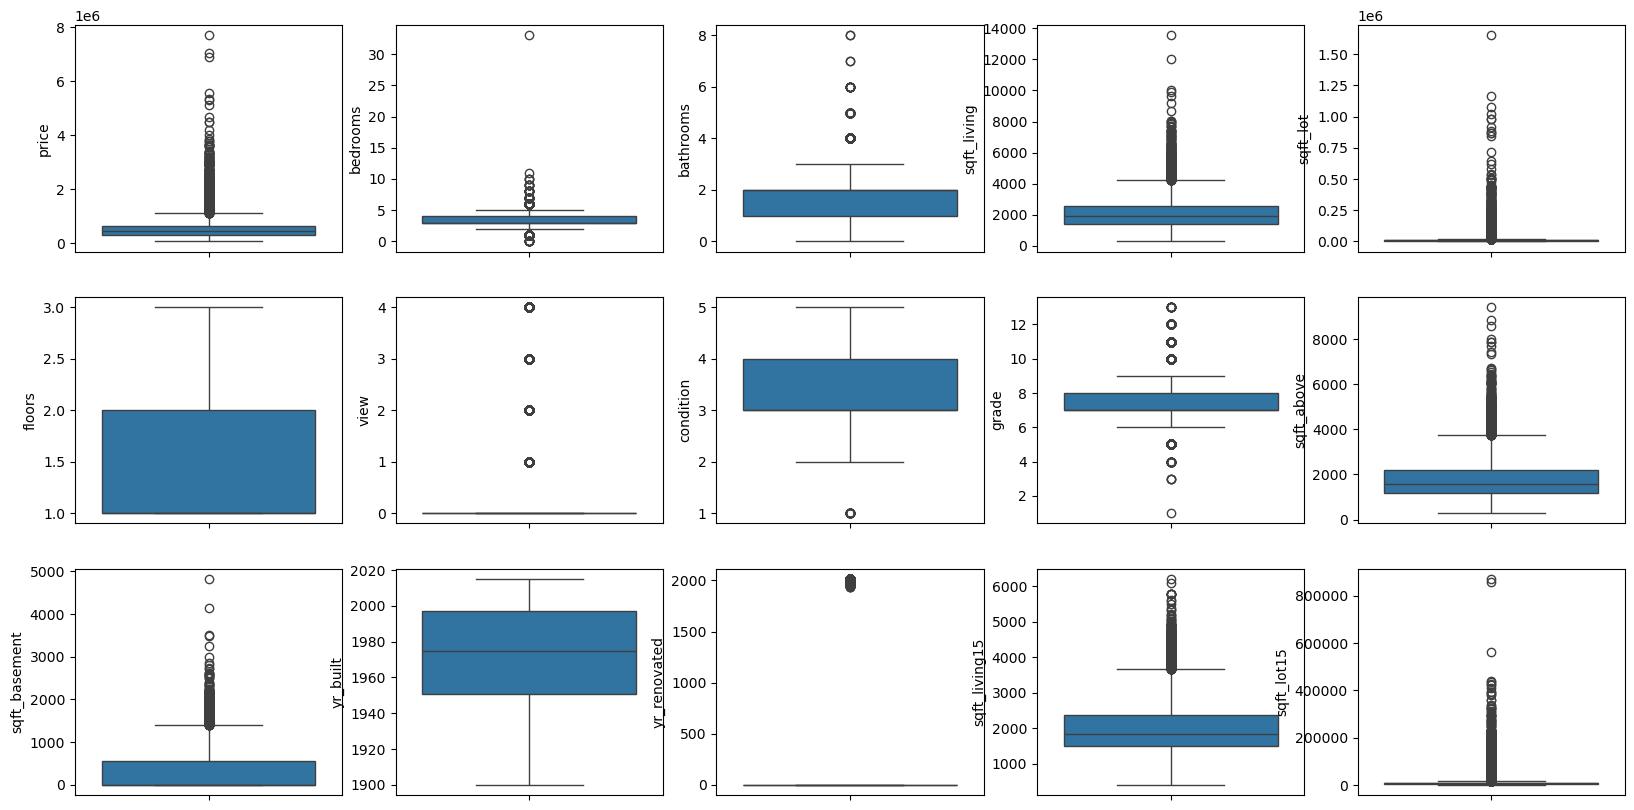

In [8]:
cols_boxplot = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view', 'condition',
                'grade','sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']

for i in range(len(cols_boxplot)):
    plt.subplot(3,5,i+1)
    sns.boxplot(df_raw[cols_boxplot[i]])

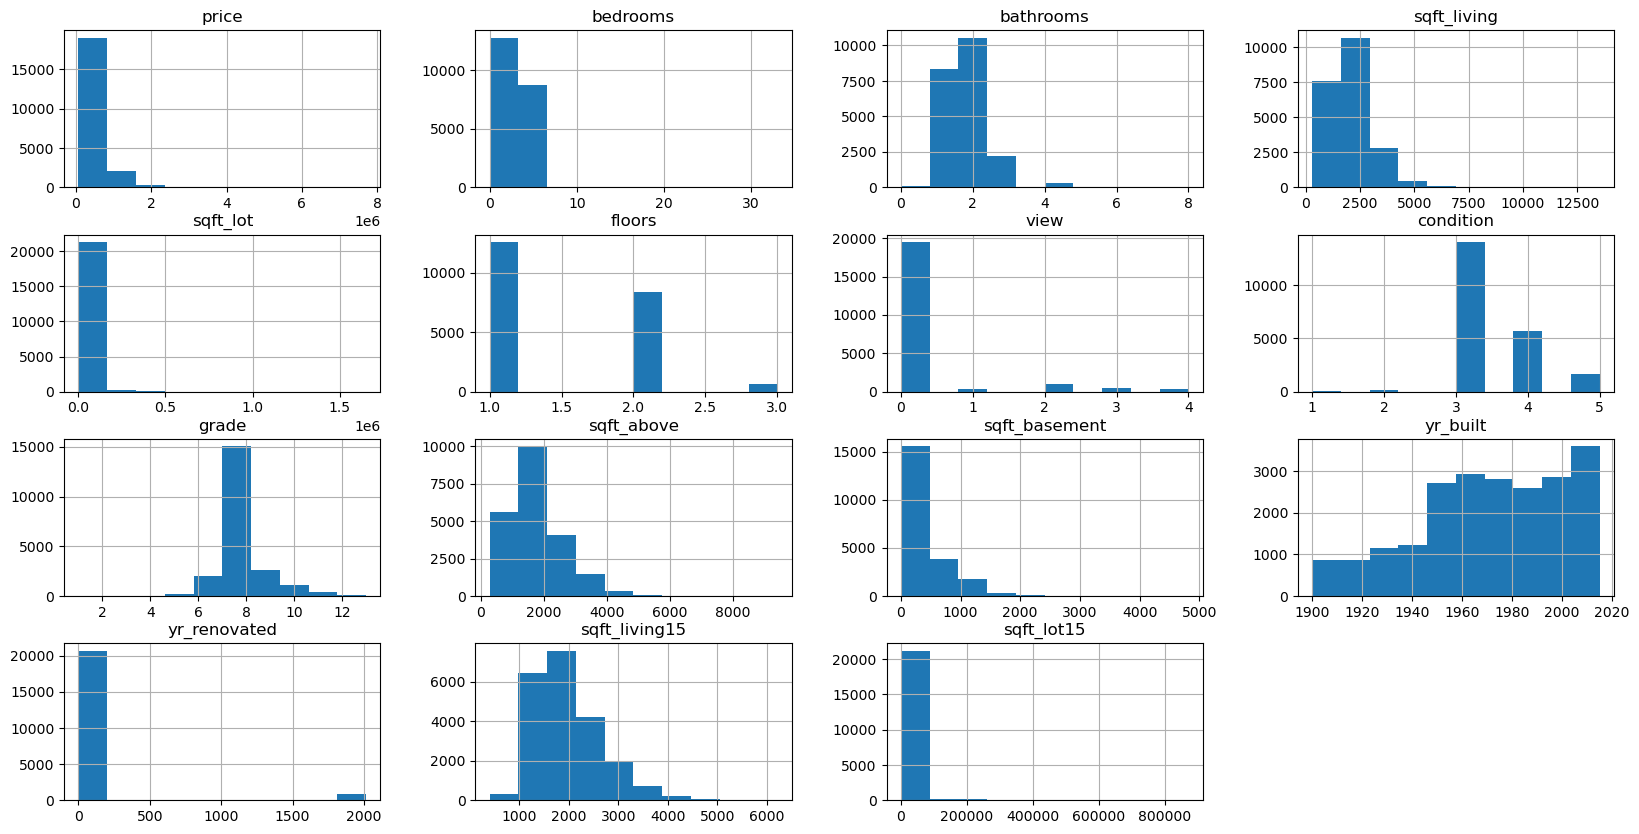

In [9]:
df_raw[cols_boxplot].hist();

In [23]:
df_raw[['price','waterfront']].groupby('waterfront').mean().reset_index()

,waterfront,price
0,0,531563.60
1,1,1661876.02


   waterfront     id
0           0  21450
1           1    163


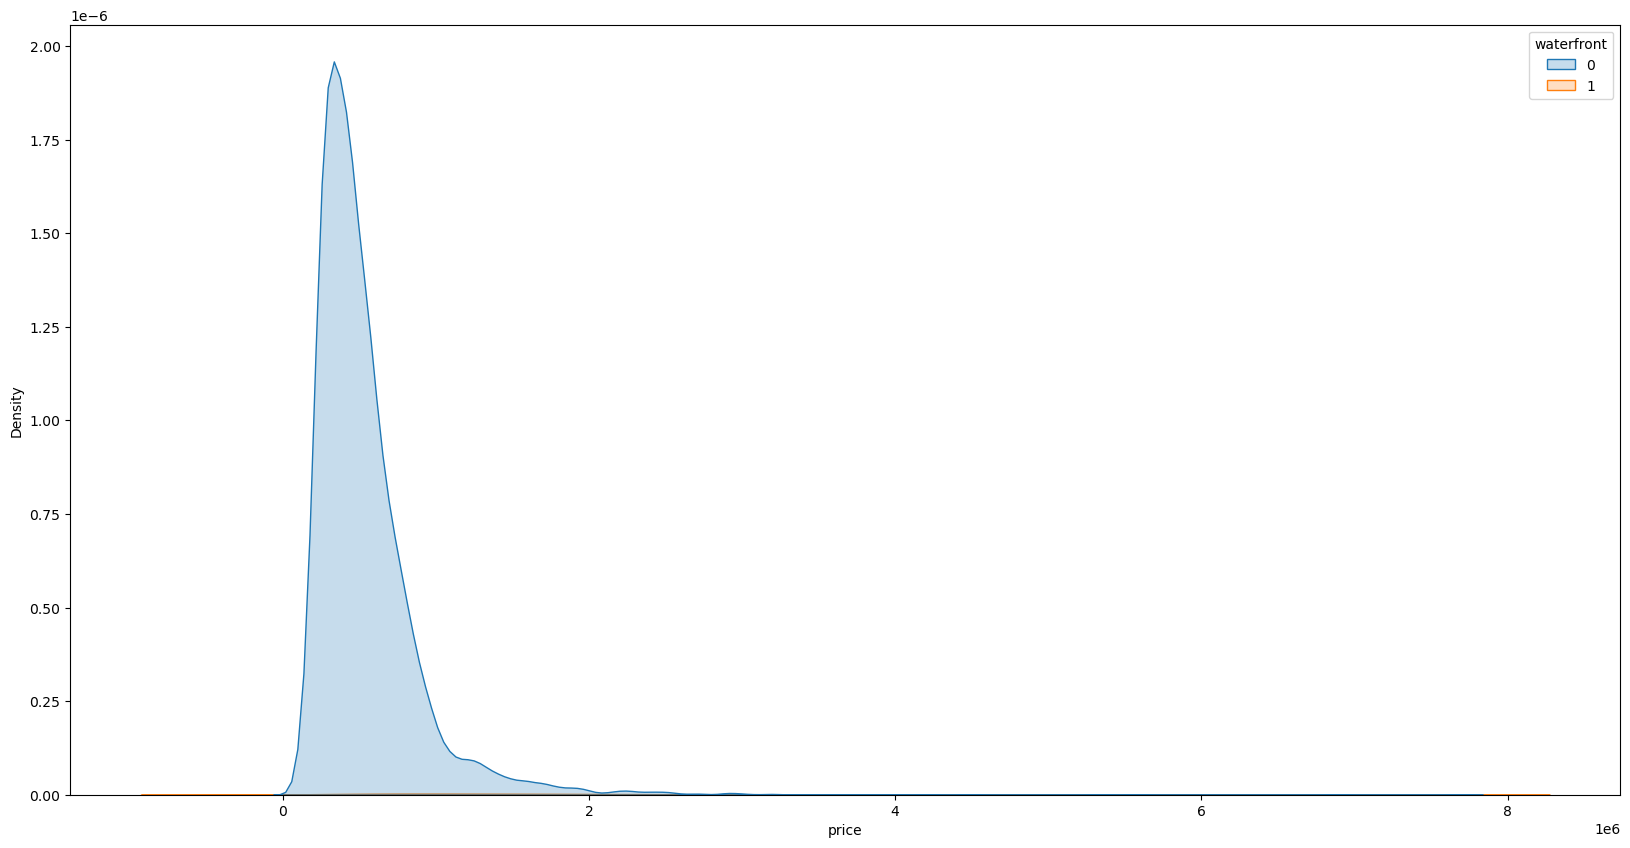

In [22]:
print(df_raw[['id','waterfront']].groupby('waterfront').count().reset_index())
sns.kdeplot(data=df_raw, x="price", hue="waterfront", fill=True);

In [20]:
df_raw[['id','waterfront']].groupby('waterfront').count().reset_index()

,waterfront,id
0,0,21450
1,1,163


#### 1.5 Cleaning

In [7]:
# correção de outlier
'''
assumo que o registro com 33 quartos é um erro de digitação,
considerando que os valores de preço, sala de estar, terreno
e numero de banheiros estão na média dos imóveis de 3 quartos
'''
df_raw[df_raw['bedrooms'].isin([3,33])]

price = df_raw[df_raw['bedrooms']==3]['price'].mean()
sqft_lot = df_raw[df_raw['bedrooms']==3]['sqft_lot'].mean()
sqft_living = df_raw[df_raw['bedrooms']==3]['sqft_living'].mean()
bath = df_raw[df_raw['bedrooms']==3]['bathrooms'].mean()

df_raw.loc[df_raw['bedrooms']==33,'bedrooms'] = 3

### 2. Hypothesis

Verdadeiro. O valor dos imóveis com vista para a água apresentam variação de 207.45% em relação à média geral


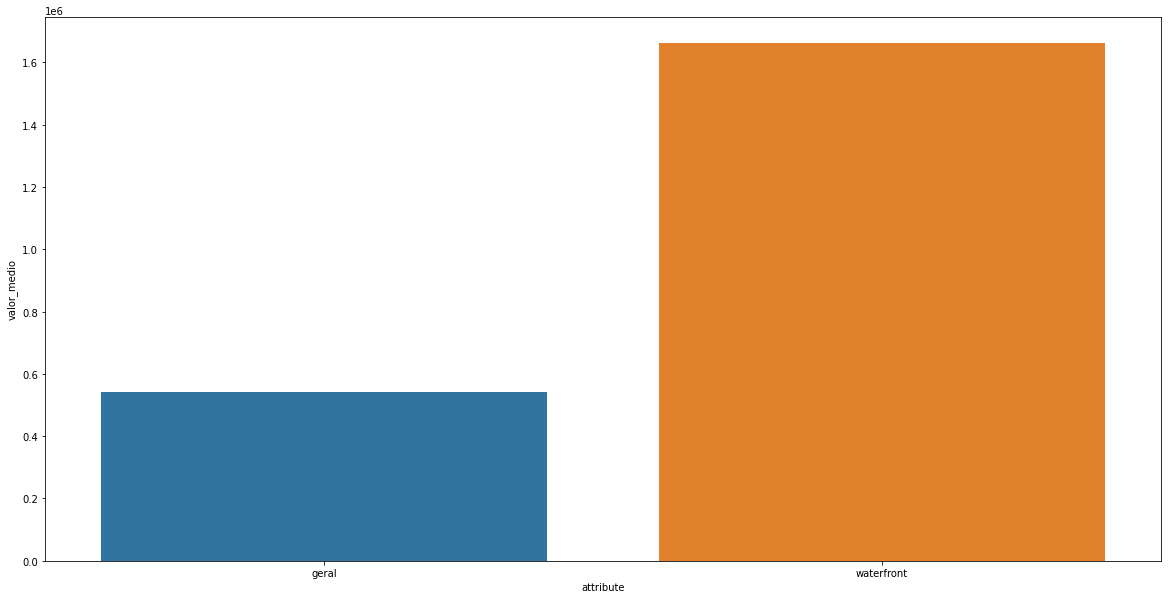

In [14]:
# H1: Imóveis com vista para água são 20% mais caros que a média

_all = df_raw['price'].mean()
w_water = df_raw[df_raw['waterfront']==1]['price'].mean()
df_h1 = pd.DataFrame({'attribute': ['geral','waterfront'], 'valor_medio': [_all, w_water]})
df_h1['pct'] = df_h1['valor_medio'].pct_change()
result = ''
if df_h1.loc[1,'valor_medio'] > df_h1.loc[0,'valor_medio']:
    result = 'Verdadeiro'
else: 'Falso'

print('{:}. O valor dos imóveis com vista para a água apresentam variação de {:.2f}% em relação à média geral'.format(result, df_h1.loc[1,'pct']*100))
sns.barplot(data=df_h1, x='attribute', y='valor_medio');

Diferenca percentual: -0.44%


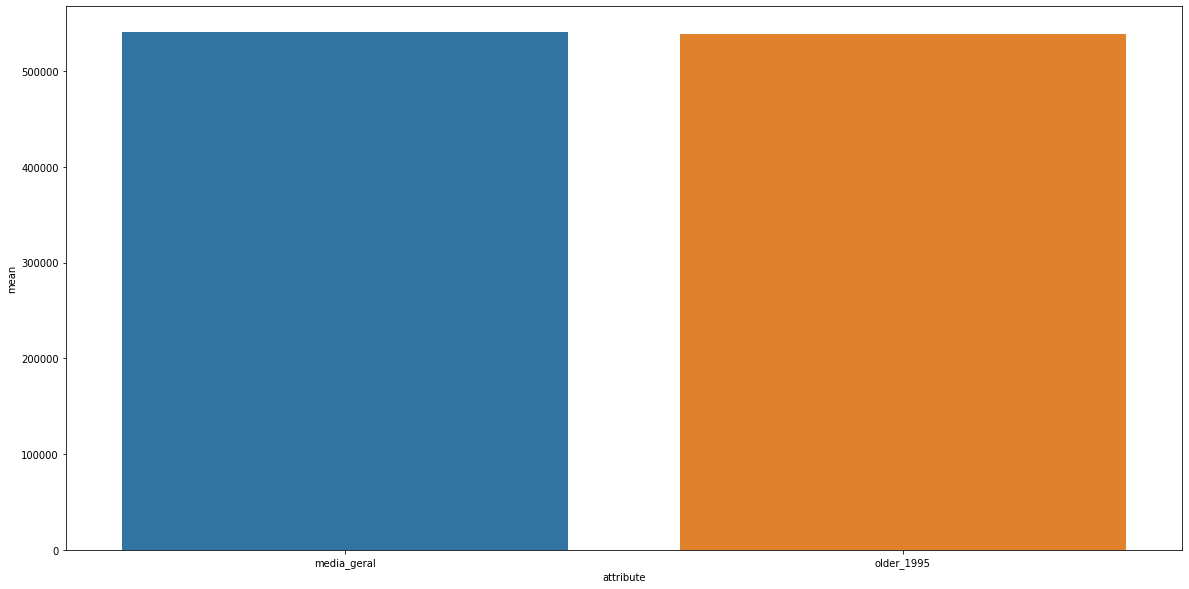

In [15]:
## H2: Imóveis com data de construção menor que 1955 são 50% mais baratos na média

_all = df_raw['price'].mean()
older_1955 = df_raw[df_raw['yr_built'] < 1955]['price'].mean()
df_h2 = pd.DataFrame({'attribute': ['media_geral','older_1995'], 'mean': [_all, older_1955]})
df_h2['pct'] = df_h2['mean'].pct_change()

print('Diferenca percentual: {:.2f}%'.format(df_h2.loc[1,'pct']*100))
sns.barplot(data=df_h2, x='attribute', y='mean');

Verdadeiro. A diferença percentual da área total dos imóveis sem porão em relação aos imóveis com porão é de 22.79%


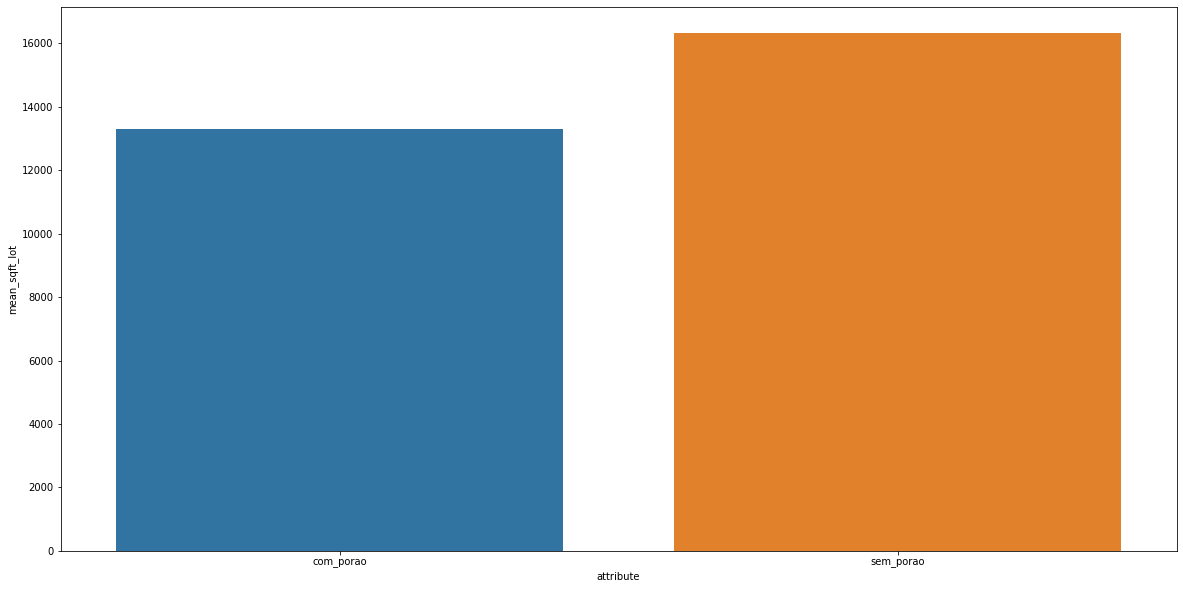

In [16]:
# H3: Imóveis sem porão são, em media, 40% maiores do que os imóveis com porão

sem_porao = df_raw[df_raw['sqft_basement']==0]['sqft_lot'].mean()
com_porao = df_raw[df_raw['sqft_basement']!=0]['sqft_lot'].mean()
df_h3 = pd.DataFrame({'attribute': ['com_porao','sem_porao'], 'mean_sqft_lot': [com_porao, sem_porao]})
df_h3['pct'] = df_h3['mean_sqft_lot'].pct_change()
result = ''
if df_h3.loc[0,'mean_sqft_lot'] < df_h3.loc[1,'mean_sqft_lot']:
    result = 'Verdadeiro'
else: result = 'Falso'

print('{:}. A diferença percentual da área total dos imóveis sem porão em relação aos imóveis com porão é de {:.2f}%'.format(result, df_h3.loc[1,'pct']*100))
sns.barplot(data=df_h3, x='attribute', y='mean_sqft_lot');

Falso. A variação percentual do valor médio dos imóveis ano a ano é de 0.70%


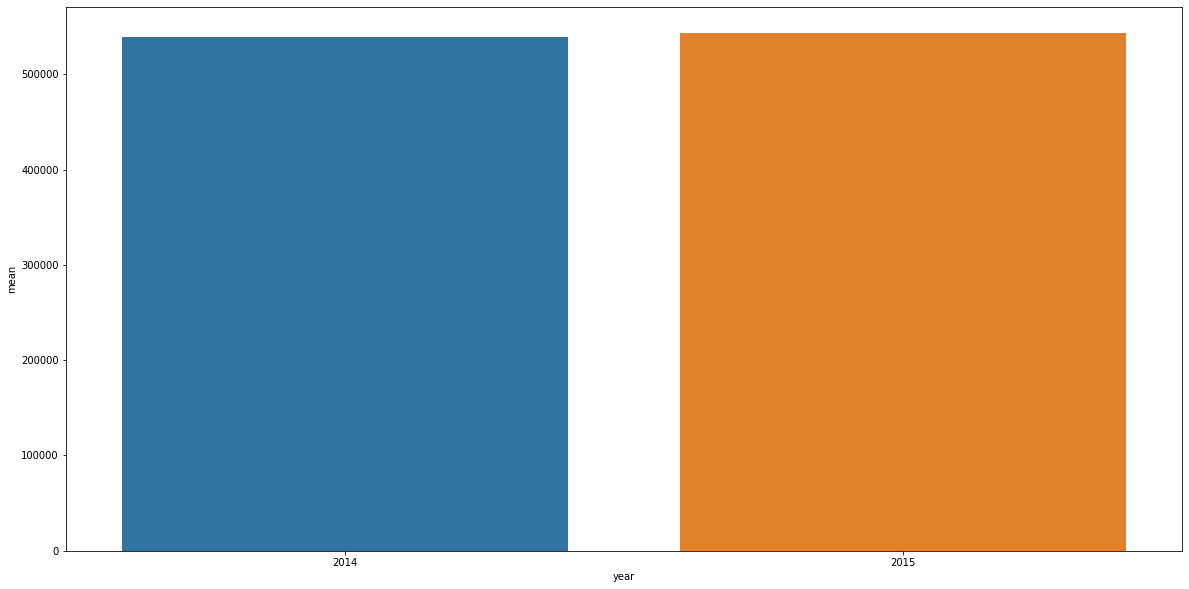

In [17]:
# H4: Crescimento do preço dos imóveis Yoy é de 10%

df_raw['year'] = pd.to_datetime(df_raw['date']).dt.strftime('%Y')
df_h4 = df_raw[['year','price']].groupby('year').mean().reset_index()
df_h4 = df_h4.rename(columns={'price': 'mean'})
df_h4['pct'] = df_h4['mean'].pct_change()
result = ''
if df_h4.loc[1,'mean'] == 0.1:
    result = 'Verdadeiro'
else: result = 'Falso'
    
print('{:}. A variação percentual do valor médio dos imóveis ano a ano é de {:.2f}%'.format(result, df_h4.loc[1,'pct']*100))
sns.barplot(data=df_h4, x='year', y='mean');

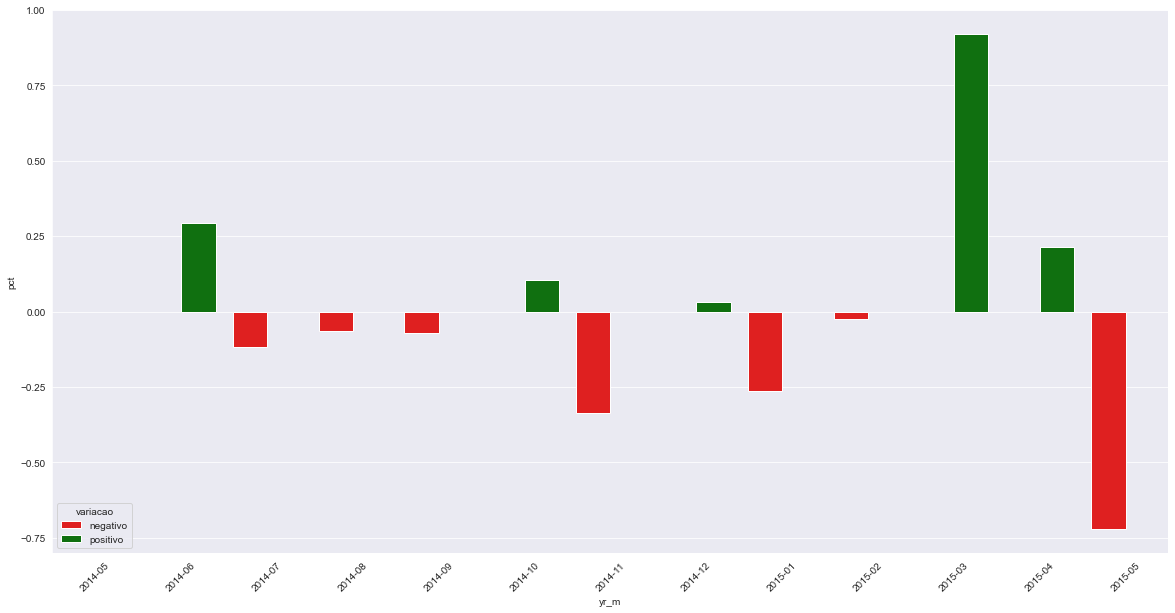

In [18]:
## H5: Imóveis com 3 banheiros tem um crescimento MoM de 15%

df_h5 = df_raw.loc[df_raw['bathrooms']==3,:].copy()
df_h5['yr_m'] = df_raw['date'].dt.strftime('%Y-%m')
df_h5 = df_h5[['yr_m','price']].groupby('yr_m').sum().reset_index()
df_h5 = df_h5.rename(columns={'price': 'mean'})
df_h5['pct'] = df_h5['mean'].pct_change()
df_h5['variacao'] = df_h5['pct'].apply(lambda x: 'positivo' if x>0 else 'negativo')

sns.set_style('darkgrid')
color = ['red','green']
p = sns.barplot(data=df_h5, x='yr_m', y='pct', hue='variacao', palette=color);
plt.xticks(rotation=45);

Diferenca percentual: 15.18%


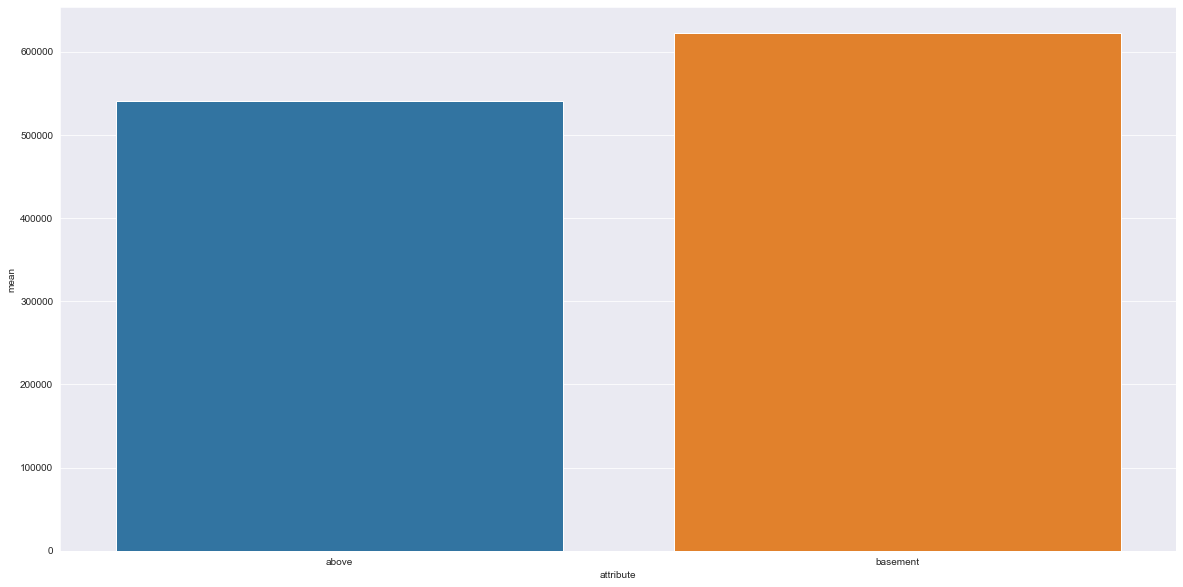

In [19]:
## H6: Imóveis com sótão são 20% mais caros do que imóveis com porão

above = df_raw.loc[df_raw['sqft_above']>0,'price'].mean()
basement = df_raw.loc[df_raw['sqft_basement']>0,'price'].mean()
df_h6 = pd.DataFrame([['above',above],['basement',basement]],columns=['attribute','mean'])
df_h6['pct'] = df_h6['mean'].pct_change()

print('Diferenca percentual: {:.2f}%'.format(df_h6.loc[1,'pct']*100))
sns.barplot(data=df_h6, x='attribute', y='mean');

Verdadeiro. A diferença da média do valor dos imóveis antigos reformados em relação aos imóveis novos é de 23.15%


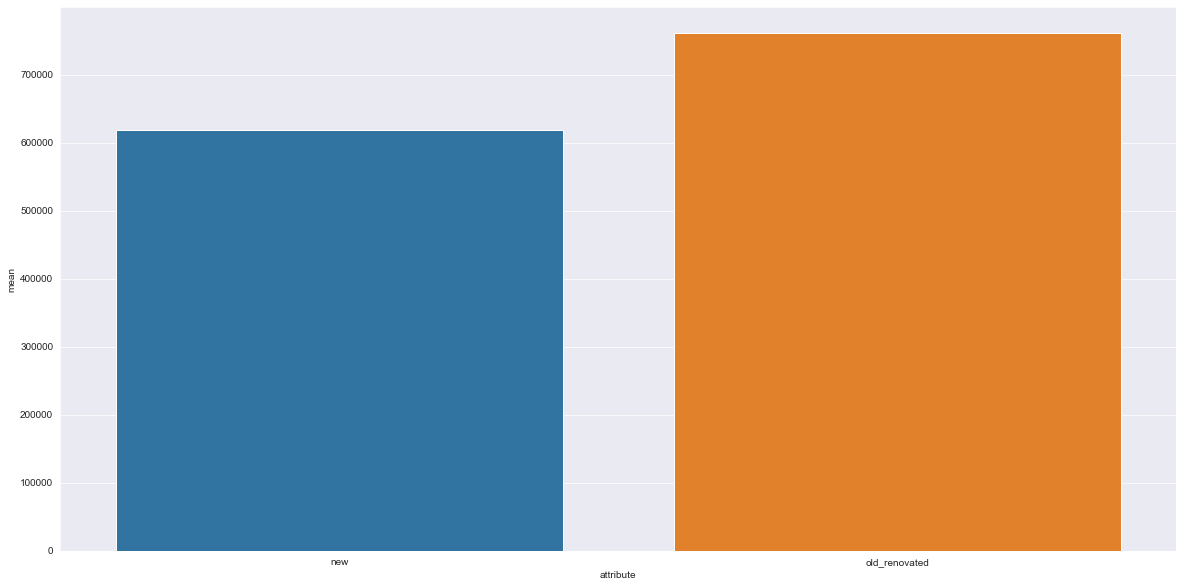

In [20]:
# H7: Imóveis antigos reformados são 30% mais caros do que imóveis novos
    #imóvel antigo = ano de construção anterior a 2000

old = df_raw.loc[(df_raw['yr_renovated']>0) & (df_raw['yr_built'].between(1,2000)),'price'].mean()
new = df_raw.loc[(df_raw['yr_renovated']==0) & (df_raw['yr_built']>=2000),'price'].mean()
df_h7 = pd.DataFrame([['new',new],['old_renovated',old]],columns=['attribute','mean'])
df_h7['pct'] = df_h7['mean'].pct_change()
result = ''
if df_h7.loc[1,'mean'] > df_h7.loc[0,'mean']:
    result = 'Verdadeiro'
else: result = 'Falso'
    
print('{:}. A diferença da média do valor dos imóveis antigos reformados em relação aos imóveis novos é de {:.2f}%'.format(result, df_h7.loc[1,'pct']*100))
sns.barplot(data=df_h7, x='attribute', y='mean');

Diferenca percentual: -58.19%


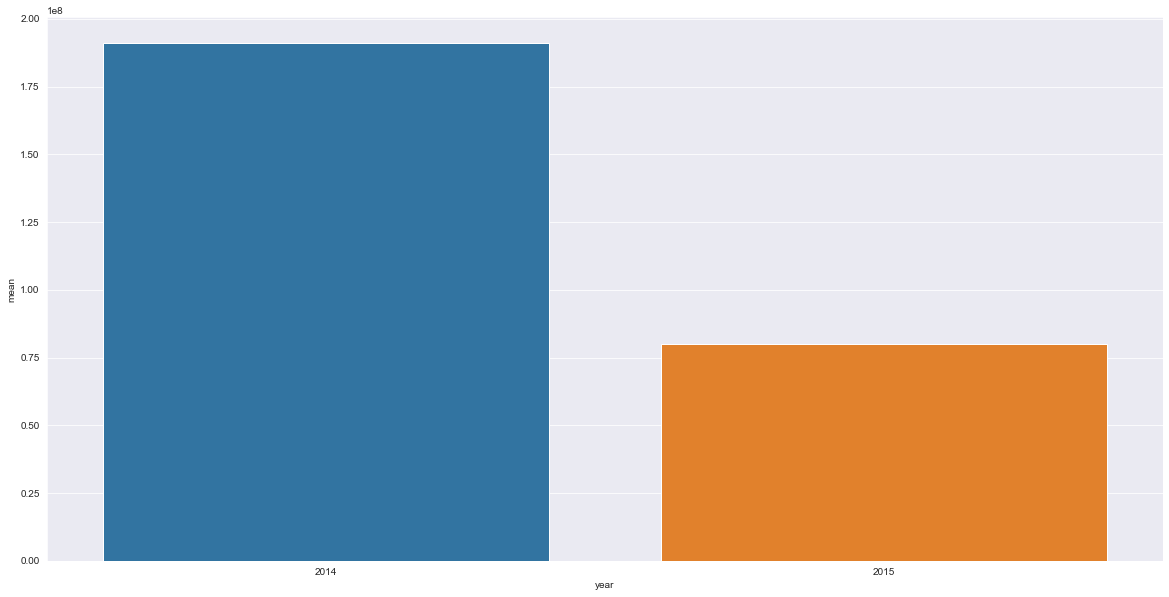

In [21]:
# H8: Imóveis com vista pra água tem um crescimento YoY de 20%
df_h8 = df_raw[df_raw['waterfront']==1].copy()
df_h8 = df_h8[['year','price']].groupby('year').sum().reset_index()
df_h8 = df_h8.rename(columns={'price': 'mean'})
df_h8['pct'] = df_h8['mean'].pct_change()

print('Diferenca percentual: {:.2f}%'.format(df_h8.loc[1,'pct']*100))
sns.barplot(data=df_h8, x='year', y='mean');

Diferenca percentual: 24.23%


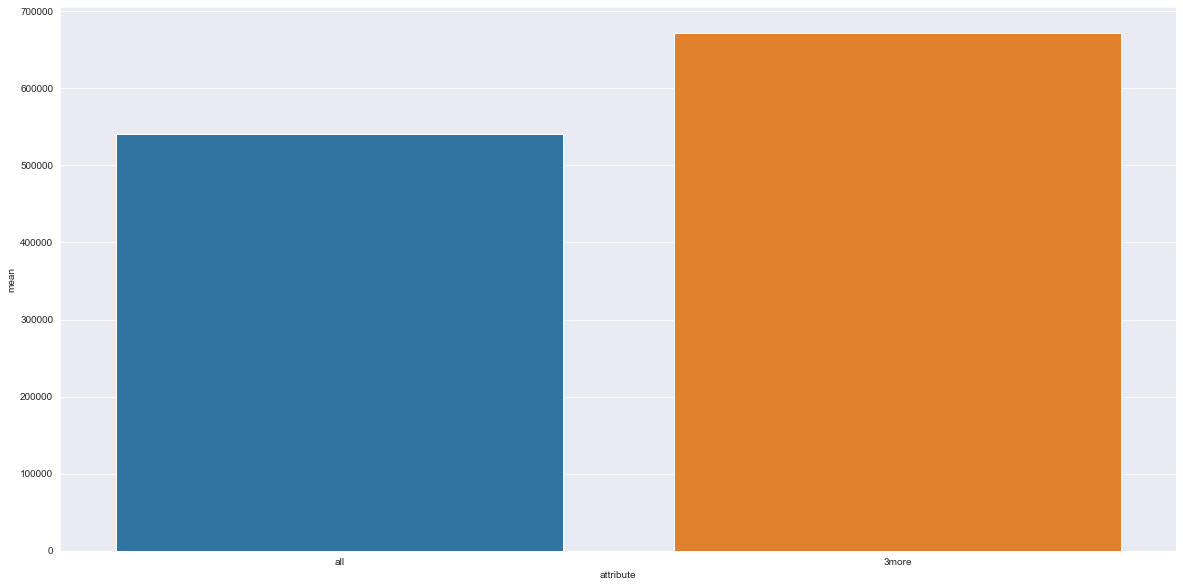

In [22]:
# H9: Imóveis com mais de 3 quartos são 30% mais caros que a média

_3more = df_raw.loc[df_raw['bedrooms']>3,'price'].mean()
_all = df_raw['price'].mean()
df_h9 = pd.DataFrame([['all',_all],['3more',_3more]],columns=['attribute','mean'])
df_h9['pct'] = df_h9['mean'].pct_change()

print('Diferenca percentual: {:.2f}%'.format(df_h9.loc[1,'pct']*100))
sns.barplot(data=df_h9, x='attribute', y='mean');

Diferenca percentual: -16.22%


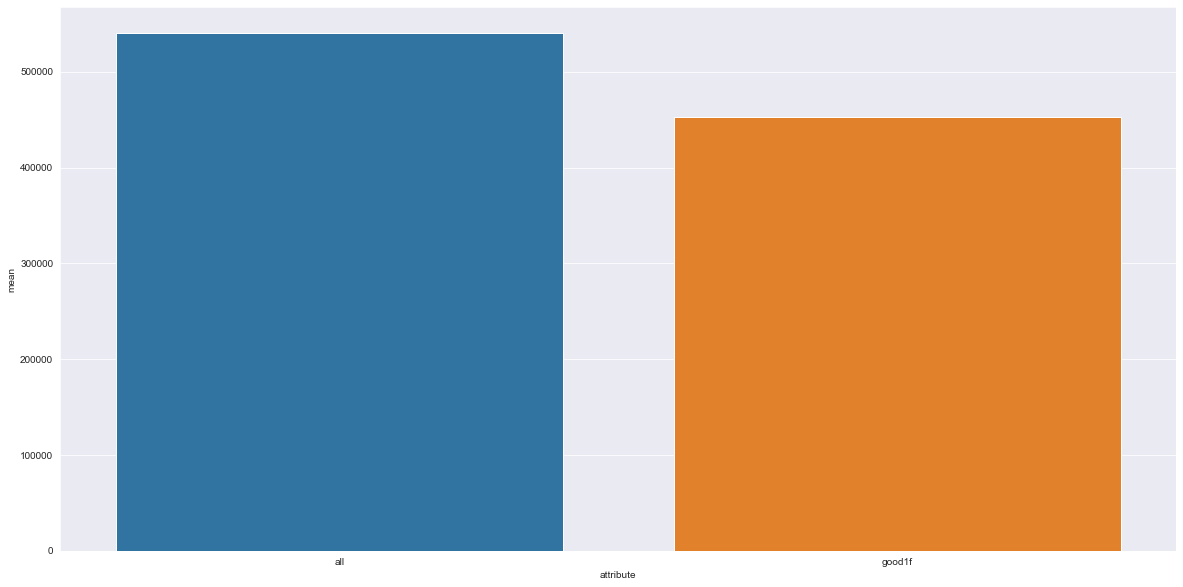

In [23]:
# H10: Imóveis em boas condições com 1 andar são 20% mais caros que a média

df_raw['condition_type'] = df_raw['condition'].apply(lambda x: 'bad' if x <= 2 else 'regular' if x in([3,4]) else 'good' )
good1f = df_raw.loc[(df_raw['floors']==1)&(df_raw['condition_type']=='regular'),'price'].mean()
all = df_raw['price'].mean()
df_h0 = pd.DataFrame([['all',all],['good1f',good1f]], columns=['attribute','mean'])
df_h0['pct'] = df_h0['mean'].pct_change()

print('Diferenca percentual: {:.2f}%'.format(df_h0.loc[1,'pct']*100))
sns.barplot(data=df_h0, x='attribute', y='mean');

##### Construção do algoritmo da solução

**Engenharia de atributos**

In [8]:
#new attributes
data = df_raw.copy()

data['sn_compra'] = 'NA'
data['condition_type'] = 'NA'

data['sell_price'] = 0.0
data['profit'] = 0.0
data['month'] = data['date'].dt.strftime('%m').astype('int64')
data['season'] = data['month'].apply(lambda x: 'winter' if x in(12,1,2) else
                                               'spring' if x in(3,4,5) else
                                               'summer' if x in(6,7,8) else 'fall' )
data['sn_compra'] = data['sn_compra'].astype('string')
data['condition_type'] = data['condition_type'].astype('string')
data['condition_type'] = data['condition'].apply(lambda x: 'good' if x==5 else 'regular' if x in(3,4) else 'bad')
data['season'] = data['season'].astype('string')

# definindo mediana do custo por região
regional_median = data[['zipcode','price']].groupby('zipcode').median().reset_index().copy()
regional_median.columns = ['zipcode','regional_median']
regional_median.to_csv('../data/interim/regional_median.csv',index=False)

# definindo mediana do custo por região/estação
season_median = data[['price','zipcode','season']].groupby(['zipcode','season']).median('price')
season_region_median = season_median.rename(columns={'price': 'season_median'}).reset_index(drop=False)
season_region_median.to_csv('../data/interim/season_region_median.csv',index=False)

**Criando filtros**

In [9]:
f_zipcode = widgets.Dropdown(
    options = data['zipcode'].sort_values().unique().tolist(),
    description = 'Zipcode',
    disable = False
)

f_filters = widgets.Checkbox(
    value=False,
    description='Disable filter',
    disabled=False,
    indent=False
)

**Definição dos imóveis para compra**

In [10]:
# adicionando a mediana regional para cada imóvel
purchase = pd.merge(data,regional_median,how='left',on='zipcode').copy()

purchase['sn_compra'] = purchase.apply(
    lambda x: 'y' if (x['price'] < x['regional_median']) & (x['condition_type']=='good') else 'n',
    axis=1 )

purchase_list = purchase.drop(columns=['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront',
                                  'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
                                  'yr_renovated', 'month'])

purchase_list.to_csv('../data/processed/purchase_list.csv',index=False)                                  

**Coleta dos dados de geolocalização dos imóveis elegíveis**

In [ ]:
# dados de geolocalização

geolocation = purchase_list.loc[purchase_list['sn_compra'] == 'y'][['id', 'lat', 'long']].copy().reset_index( drop=True )
geolocator = Nominatim( user_agent='geoapiExercises' )
geolocation['street'] = 'NA'
geolocation['house_num'] = 'NA'
geolocation['city'] = 'NA'
geolocation['neighbourhood'] = 'NA'
geolocation['state'] = 'NA'

for i in range( len( geolocation ) ):
    query = str( geolocation.loc[i, 'lat'] ) + ',' + str( geolocation.loc[i, 'long'] )
    response = geolocator.reverse( query, timeout=10000 )
    response = pd.json_normalize( response.raw['address'] )
    geolocation.iloc[i, 3] = response.apply( lambda x: x['road'] if 'road' in response.columns else 'NA', axis = 1 )    
    geolocation.iloc[i, 4] = response.apply( lambda x: x['house_number'] if 'house_number' in response.columns else 'NA', axis = 1 )
    geolocation.iloc[i, 5] = response.apply( lambda x: x['city'] if 'city' in response.columns else 'NA', axis = 1 )
    geolocation.iloc[i, 6] = response.apply( lambda x: x['neighbourhood'] if 'neighbourhood' in response.columns else
                                                       x['county'] if 'county' in response.columns else 'NA', axis = 1 )
    geolocation.iloc[i, 7] = response.apply( lambda x: x['state'] if 'state' in response.columns else 'NA', axis = 1 )
geolocation['address'] = geolocation['street'] + ', ' + geolocation['house_num']

geolocation.to_csv('../data/processed/geoloc.csv', index=False)

In [11]:
geolocation = pd.read_csv('../data/processed/geoloc.csv')

**Definição do preço de revenda**

In [ ]:
sell = pd.merge(purchase_list,season_region_median,how='inner',on=['zipcode'])
sell = sell.loc[sell['sn_compra'] == 'y']
sell['sell_price'] = sell.apply(lambda x: x['price'] * 1.3 if x['price'] < x['season_median'] else x['price'] * 1.1, axis=1)
sell['diff_price'] = sell.apply(lambda x: np.sqrt((x['sell_price']-x['season_median'])**2),axis=1)

aux = sell[['id','diff_price']].groupby('id').min().reset_index(drop=False)
aux['sn_vende'] = 'y'

sell = pd.merge(sell,aux,how='left',on=['id','diff_price']).drop_duplicates(subset=['id','diff_price'])
sell = sell.loc[sell['sn_vende']=='y']

sell['profit'] = sell['sell_price'] - sell['price']

sell = sell.drop(columns=['date','sn_compra','condition_type','regional_median','season_x','season_median','diff_price','sn_vende'])

sell_list = pd.merge(sell,geolocation[['id','address','neighbourhood','city']],how='left',on='id').rename(columns={'season_y':'season'})

sell_list.to_csv('../data/processed/sell_list.csv',index=False)

In [44]:
# lucro total
sell_list = pd.read_csv('../data/processed/sell_list.csv')
sell_list['profit'].sum()

72079180.8

In [43]:
# top3 regions with more available houses to sell
sell_list[['id','zipcode']].groupby('zipcode').count().sort_values('id',ascending=False).head(1).reset_index()

,zipcode,id
0,98042,49


In [42]:
# top3 most valuable regions
sell_list[['profit','zipcode']].groupby('zipcode').sum().sort_values('profit',ascending=False).head(1).reset_index()

,zipcode,profit
0,98006,6816570.0


In [39]:
# most valuable regions per season
a = sell_list[['profit','zipcode','season']].groupby(['season','zipcode']).sum().sort_values(['season','profit'],ascending=False).reset_index()
b = sell_list[['profit','zipcode','season']].groupby(['season','zipcode']).sum().groupby('season').max().reset_index()
pd.merge(a,b,how='right', on=['season','profit'])

,season,zipcode,profit
0,fall,98006,3100530.0
1,spring,98004,2408160.0
2,summer,98006,3362040.0
3,winter,98117,1405035.0


**Visualização dos imóveis para compra**

In [151]:
def data_viz( df, region ):
    plot = df[df['zipcode']==region][['id','price','zipcode','regional_median','condition_type','sn_compra']]
    plot['color'] = plot['sn_compra'].apply(lambda x: 'lightgray' if x == 'n' else 'blue')
     
    fig = go.Figure()
    
    # Add traces
    fig.add_trace(go.Scatter(y=plot['price'], 
                        marker_color=plot['color'],
                        mode='markers',
                        text='ID: '+plot['id'].astype('string')+' | Region: '+plot['zipcode'].astype('string')+' | Condition: ' + plot['condition_type'] + ' | Price: US$' + plot['price'].astype('string'),
                        name='Imovel'))

    fig.add_trace(go.Scatter(y=plot['regional_median'],
                        mode='lines',
                        text='Region: '+plot['zipcode'].astype('string')+' | Median: US$' + plot['regional_median'].astype('string'),
                        name='Mediana Regional'))
    
    fig.update_layout(
        xaxis_title="Houses",
        yaxis_title="Aquisition cost",
        font=dict( color="#000000" )
    )

    fig.show()
    
    return None

In [152]:
interact(data_viz, df=fixed(purchase_list), region = f_zipcode);

**Visualização dos imóveis para compra/revenda no mapa**

In [162]:
def make_map( house_list, region, filters ): 
    
    map_data = house_list

    if filters:
        map_data
    else:
        map_data = map_data.loc[map_data['zipcode']==region]
    
    _map = px.scatter_mapbox( map_data,
                              lat='lat',
                              lon='long',
                              hover_name='address',                              
                              color='season',
                              color_discrete_sequence=px.colors.qualitative.Dark2,
                              zoom=10,
                              text='ID: '+map_data['id'].astype('string'),
                              hover_data=dict( lat=False, long=False, season=False)
                            )

    _map.update_layout(mapbox_style='open-street-map')
    _map.update_layout(height=600, margin = {'r':0,'t':0,'l':0,'b':0})
    _map.show()
    
    return None

In [163]:
interact( make_map, house_list=fixed( sell_list ), region=f_zipcode, filters=f_filters );